In [1]:
import pandas as pd
import pyBigWig 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# SUZ12 ChIP in Fibroblast from https://chip-atlas.dbcls.jp/data/hg38/eachData/bw/SRX3468052.bw
chip=pyBigWig.open('data/chip/SRX3468052_suz12_fib.bw') 

In [3]:
# filter blacklist
def bl(t):
    bl=pd.read_table('data/ref/hg38-blacklist.v2.bed',header=None)
    bl['r']=bl.apply(lambda x: set(range(x[1],x[2])),axis=1)
    bg=bl.groupby(0)['r'].apply(list)
    bg=bg.apply(lambda x:set.union(*x))   
    t['r']=t.apply(lambda x: set(range(x[1],x[2])),axis=1)
    t['bl']=t.apply(lambda x: len(x['r'].intersection(bg[x['ch']])),axis=1)
    t=t[t['bl']==0].drop('r',axis=1)
    return t
# get PRC levels in HMRs
def prc(bw_folder,hmr): 
    t=pd.read_csv('data/DNAm/'+hmr,sep='\t',header=None,usecols=[0,1,2,4])
    t=t[~t[0].isin(['chrX','chrY','chrM'])].copy()
    t.columns=['ch','b','e','d']
    t['prc']=t.apply(lambda x:chip.stats(x[0],x[1],x[2])[0],axis=1)
    print(len(t))
    t=bl(t) 
    return t
# get DNAm levels in HMRs
def prcm(dft,bw_folder,cells): 
    path='data/DNAm/'+bw_folder+'/'
    for cell in cells:
        bs=[]
        print(cell,end=',')
        bw=pyBigWig.open(path+cell+'.bw')
        for i,r in dft.iterrows():
            if (i % 1000) == 0:print('.',end='')
            bs.append(bw.stats(r['ch'],r['b'],r['e'])[0])
        print()
        dft[cell]=bs
    dft=dft.dropna().copy().round(3)
    return dft
# adjust HMR_DNAms for length of HMR
def prc_cpg(dft,cells):
    c0=cells[0]
    l=dft.apply(lambda x:x['d']*[x[c0]],axis=1)
    l=[item for sublist in l for item in sublist]
    df=pd.DataFrame(l)
    df.columns=[c0]
    for cell in cells[1:]:
        l=dft.apply(lambda x:x['d']*[x[cell]],axis=1)
        l=[item for sublist in l for item in sublist]
        df[cell]=l
    return df
# plot DNAm at LMRs
def pprc(tp,color=[],title='DNAm at LMRs',r=10**5,w=3,ylabel='DNAm',figure='f'):
    if len(color)>0:
        ax=tp.rolling(r).mean().dropna().plot(figsize=(w,2),color=color)    
    else:
        ax=tp.rolling(r).mean().dropna().plot(figsize=(w,2))    
    ax.get_legend().remove()
    ax.set_xticks([])
    ax.set_xlabel('LMRs ranked by PRC2 binding', fontsize=10)
    ax.set(ylabel=ylabel,title=title);
    ax.get_figure().savefig('figures/'+figure+'.png', dpi=600,bbox_inches='tight')
# plot DNAm at High-PRC2 LMRs
def pprch(tp,n,m,color=None,labels=[],legend_title='years',figure='f',title=''):
    dg=tp.tail(round(n)).rolling(round(m)).mean().dropna()
    ax=dg.plot(figsize=(1.2,2),color=color)
    if len(labels)==0: 
        labels=tp.columns
        handles, labels = ax.get_legend_handles_labels()    
        ax.legend(handles[::-1], labels[::-1],title=legend_title,loc='center left', bbox_to_anchor=(1, 0.5))    
    else:
        handles, l = ax.get_legend_handles_labels()    
        ax.legend([handles[-1],handles[0]], [labels[-1],labels[0]],title=legend_title,loc='center left', bbox_to_anchor=(1, 0.5))    
    ax.set_xticks([])
    ax.set_xlabel('PRC2 binding', fontsize=10)  
    ax.set_title('DNAm at High-PRC2 LMRs')    
    ax.get_figure().savefig('figures/'+figure+'.png', dpi=600,bbox_inches='tight')
    return dg

In [4]:
# get PRC levels in HMRs
bw_folder='fibroblast/GSE79798_DNAm_fibroblast'
hmr='fibroblast/sebastiano_fetal_fibroblast_wgbs.hmr'
f=prc(bw_folder,hmr)

77733


In [5]:
# get DNAm levels in HMRs
cells=['4','7','10','31','33']
f=f.sort_values('prc').reset_index()
f=prcm(f,bw_folder,cells).round(3)
f.to_csv('data/results/sebastiano_fetal_fibroblast_wgbs_hmr_SRX3468052_suz12_fib.csv')

4,...........................................................................
7,...........................................................................
10,...........................................................................
31,...........................................................................
33,...........................................................................


In [6]:
# adjust HMR_DNAms for length of HMR
cells=['4','7','10','31','33']
f=pd.read_csv('data/results/sebastiano_fetal_fibroblast_wgbs_hmr_SRX3468052_suz12_fib.csv',index_col=0)
fp=prc_cpg(f,cells)

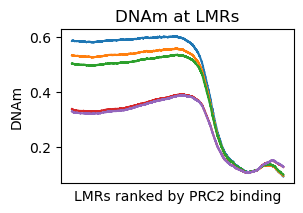

In [7]:
#plot LMRs (rolling window size=r)
dg=pprc(fp[cells],r=500000,figure='f5_c_lmr_FIB')

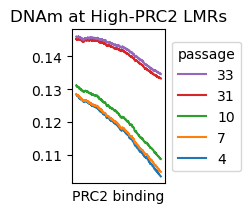

In [9]:
#plot high-PRC2 LMRs, last n CpGs, rolliwng 
dg=pprch(fp[cells],n=1000000,m=700000,legend_title='passage',figure='f5_c_prc_FIB')